In [352]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.csgraph import minimum_spanning_tree

def transitive_closure(distance_matrix, alpha):
    adj_matrix = distance_matrix <= alpha
    n = adj_matrix.shape[0]
    closure = adj_matrix.copy()
    
    # Warshall's algorithm for transitive closure
    for k in range(n):
        for i in range(n):
            for j in range(n):
                closure[i,j] = closure[i,j] or (closure[i,k] and closure[k,j])
    
    return closure

def get_alpha_levels(dist_matrix, points):
    
    ## Step 1: Compute Minimum Spanning Tree (MST)
    mst = minimum_spanning_tree(dist_matrix).toarray()

    ## Step 2: Find all unique distances in the MST
    mst_distances = sorted(set(mst[mst > 0].flatten()))
    
    alpha_levels = []
    for alpha in mst_distances:
        closure = transitive_closure(dist_matrix, alpha)
        # Find connected components
        components = []
        visited = set()
        for i in range(len(points)):
            if i not in visited:
                component = set(np.where(closure[i])[0])
                components.append(component)
                visited.update(component)
        alpha_levels.append((alpha, components))
    
    return alpha_levels

#-----dist-------

def create_dist_matrix(point_ids):
    N = len(point_ids)
    res = [[np.abs(point_ids[i][0] - point_ids[j][0]) for j in range(N)] for i in range(N)]
    return np.asarray(res)

def create_dist_matrix_2(point_ids):
    N = len(point_ids)
    res = [[np.linalg.norm(point_ids[i] - point_ids[j])/np.sqrt(2) for j in range(N)] for i in range(N)]
    return np.asarray(res)

from shapely.geometry import Point, MultiPoint

def find_coincident_shapely(points, tolerance=1e-6):
    multipoint = MultiPoint(points)
    groups = []
    
    while len(multipoint.geoms) > 0:
        p = multipoint.geoms[0]
        buffer = p.buffer(tolerance)
        cluster = [g for g in multipoint.geoms if buffer.contains(g)]
        
        if len(cluster) > 1:
            groups.append(np.array([(p.x, p.y) for p in cluster]))
        
        # Remove processed points
        multipoint = MultiPoint([g for g in multipoint.geoms if g not in cluster])
    
    return groups

import numpy as np
from scipy.spatial.distance import cdist

def split_coincident_points(points, min_distance=0.05, tolerance=1e-6):
    dist_matrix = cdist(points, points)
    np.fill_diagonal(dist_matrix, np.inf)  # Ignore self-comparisons
    groups = []
    used_indices = set()
    
    # Find groups of coincident points
    for i in range(len(points)):
        if i not in used_indices:
            close_indices = np.where(dist_matrix[i] < tolerance)[0]
            if len(close_indices) > 0:
                groups.append(close_indices)
                used_indices.update(close_indices)
    
    # Apply corrections
    corrected_points = points.copy()
    for group in groups:
        n = len(group)
        center = np.mean(points[group], axis=0)
        
        # Calculate positions in a circle around center
        angles = np.linspace(0, n*np.pi, n, endpoint=False)
        offsets = min_distance * np.column_stack([np.cos(angles), np.sin(angles)])
        
        corrected_points[group] = center + offsets
    
    return corrected_points, groups

def split_up_coincident_points(points, min_distance=0.05, tolerance=1e-6):

    n = len(points)
        
    # Calculate positions in a circle around center
    shifts_x = np.zeros(n)
    shifts_y = np.linspace(0, n*min_distance, n, endpoint=False)
    offsets = np.column_stack([shifts_x, shifts_y])    
        
    corrected_points = points + offsets
    
    return corrected_points

import numpy as np
from scipy.spatial.distance import cdist

def get_identical_point_ids(points, tolerance=1e-6):
    dist_matrix = cdist(points, points)
    np.fill_diagonal(dist_matrix, np.inf)  # Ignore self-comparisons
    
    groups = {}
    used_indices = set()
    
    for i in range(len(points)):
        if i not in used_indices:
            # Find all points identical to this one
            identical_indices = np.where(dist_matrix[i] < tolerance)[0]
            if len(identical_indices) > 0:
                rep_point = tuple(points[i].round(6))  # Rounded as dictionary key
                groups[rep_point] = np.append(identical_indices, i)
                used_indices.update(identical_indices)
                used_indices.add(i)
    
    return groups

In [353]:
# AV
point_ids_original = np.array([
    [1.0, 1.0], #1) Андреевич
    [0.0, 0.0], # 2) Борисов
    [0.875, 0.0], # 3) Горбачевский
    [1.0, 1.0], # 4) Мазган
    [0.0, 1.0], # 5) Спиридов
    [0.75, 0.0], # 6) Лисовский
    [1.0, 0.0], # 7) Киреев
    [1.0, 0.75], # 8) Бечасный
    [0.0, 0.0], # 9) Тютчев
    [0.5, 0.0] # 10) Пестов
])

# AP
point_ids_ap = np.array([
    [1.0, 0.8], #1) Андреевич
    [0.3, 0.3], # 2) Борисов
    [0.6, 0.0], # 3) Горбачевский
    [1.0, 0.4], # 4) Мазган
    [0.2, 0.5], # 5) Спиридов
    [1.0, 0.0], # 6) Лисовский
    [1.0, 0.0], # 7) Киреев
    [1.0, 0.7], # 8) Бечасный
    [0.0, 0.8], # 9) Тютчев
    [0.2, 0.0] # 10) Пестов
])

# IK
point_ids_ik = np.array([
    [1.0, 1.0], #1) Андреевич
    [0.3, 0.2], # 2) Борисов
    [0.8, 0.0], # 3) Горбачевский
    [1.0, 0.7], # 4) Мазган
    [0.2, 0.3], # 5) Спиридов
    [0.8, 0.0], # 6) Лисовский
    [1.0, 0.0], # 7) Киреев
    [0.9, 0.5], # 8) Бечасный
    [0.1, 0.2], # 9) Тютчев
    [0.5, 0.0] # 10) Пестов
])

# VM
point_ids_vm = np.array([
    [1.0, 1.0], #1) Андреевич
    [0.0, 0.0], # 2) Борисов
    [1.0, 0.0], # 3) Горбачевский
    [1.0, 1.0], # 4) Мазган
    [0.5, 1.0], # 5) Спиридов
    [0.9, 0.0], # 6) Лисовский
    [1.0, 0.0], # 7) Киреев
    [1.0, 0.5], # 8) Бечасный
    [0.0, 0.0], # 9) Тютчев
    [0.5, 0.0] # 10) Пестов
])

0.23
0.185
0.14
0.14
0.095
0.095
0.05000000000000002
0.05000000000000002


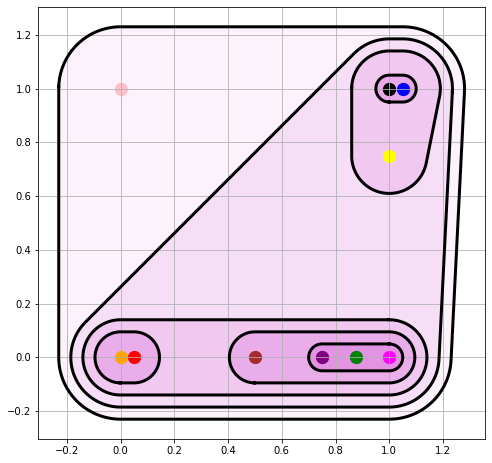

In [354]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

plots = []
colors = ['blue', 'red', 'green', 'black', 'pink', 'purple', 'magenta', 'yellow', 'orange', 'brown']
markers = ['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o']
legend = [
    "Андреевич",
    "Борисов",
    "Горбачевский",
    "Мазган",
    "Спиридов",
    "Лисовский",
    "Киреев",
    "Бечасный",
    "Тютчев",
    "Пестов"
]

point_ids = point_ids_original.copy()
#point_ids = point_ids_vm.copy()
# Split coinciding points
resres = get_identical_point_ids(point_ids)
for key in resres.keys():
    ids_coins = resres[key]
    res_spl = split_coincident_points(point_ids[ids_coins], 0.05)
    point_ids[ids_coins] = res_spl[0]

#R = create_dist_matrix(point_ids)
R = create_dist_matrix_2(point_ids)
groups = get_alpha_levels(R, point_ids)
groups.pop(0)
groups.reverse()

# point_ids = point_ids_original.copy()
# # Split coinciding points
# resres = get_identical_point_ids(point_ids)
# for key in resres.keys():
#     ids_coins = resres[key]
#     res_spl = split_coincident_points(point_ids[ids_coins])
#     point_ids[ids_coins] = res_spl[0]

r0 = 0.23

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal')

layers = len(groups)
theta = np.linspace(0, 2*np.pi, 100)
sets_hashes = list()

for i in range(layers):
    cur_indeces = groups[i][1]
    for j in range(len(cur_indeces)):
        indeces_in_layer = np.array(list(cur_indeces[j]))
        group_in_layer = point_ids[indeces_in_layer]
        
        if len(group_in_layer) == 1:
            continue
            
        cur_hash = str(indeces_in_layer)
        if cur_hash in sets_hashes:
            continue
        sets_hashes.append(cur_hash)
        
        #cur_rad = r0 - 0.02*i - 0.006*i*i
        cur_rad = r0 - 0.045*i
        circle_points = []
        
        print(cur_rad)
        
        for (x0, y0) in group_in_layer:
            x = x0 + cur_rad * np.cos(theta)
            y = y0 + cur_rad * np.sin(theta)
            circle_points.append(np.column_stack((x, y)))
        all_points = np.vstack(circle_points)
    
        # Compute convex hull (outer closed curve)
        #print(all_points)
        hull = ConvexHull(all_points)
        hull_points = all_points[hull.vertices]
    
        three_points_hull_x, three_points_hull_y = np.append(hull_points[:, 0], hull_points[0, 0]), np.append(hull_points[:, 1], hull_points[0, 1])
        ax.plot(three_points_hull_x, three_points_hull_y, 
            'k-', linewidth=3)
        plt.fill(three_points_hull_x, three_points_hull_y, 'm', alpha = (0.05 + 0.025*i))
    
# Plot the points
ids_to_plot = np.array(list(groups[0][1][0]))
points_to_plot = point_ids[ids_to_plot]
for i in range(len(points_to_plot)):
    p = plt.scatter(points_to_plot[i, 0], points_to_plot[i, 1], s=150, 
                   c=colors[i], marker=markers[i],
                   label=legend[i])
    plots.append(p)

# Create legend with 2 columns
# plt.legend(handles=plots, ncol=1, loc='upper center', prop={'size': 20},
#           bbox_to_anchor=(1.3, 0.9),
#           title='Легенда')

#ax.legend()
#plt.title("Альфа-уровни по двум измерениям с равноценными осями")
plt.grid()

plt.savefig('ours_2d.jpg')
plt.savefig('ours_2d.pdf')
plt.show()

In [239]:
groups

[(0.7071067811865475, [{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}]),
 (0.5303300858899106, [{0, 1, 2, 3, 5, 6, 7, 8, 9}, {4}]),
 (0.31819805153394637, [{0, 1, 2, 5, 6, 8, 9}, {3, 7}, {4}]),
 (0.17677669529663687, [{0, 2, 5, 6, 9}, {1, 8}, {3, 7}, {4}]),
 (0.08838834764831843, [{0, 2, 5, 6}, {1, 8}, {3}, {4}, {7}, {9}]),
 (0.035355339059327404, [{0, 6}, {1, 8}, {2}, {3}, {4}, {5}, {7}, {9}]),
 (0.035355339059327376, [{0}, {1, 8}, {2}, {3}, {4}, {5}, {6}, {7}, {9}])]

0.135
0.11000000000000001
0.11000000000000001
0.085
0.06
0.035


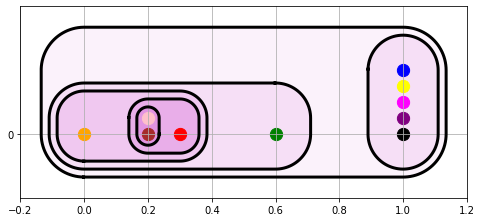

In [355]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

plots = []
colors = ['blue', 'red', 'green', 'black', 'pink', 'purple', 'magenta', 'yellow', 'orange', 'brown']
markers = ['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o']
legend = [
    "Андреевич",
    "Борисов",
    "Горбачевский",
    "Мазган",
    "Спиридов",
    "Лисовский",
    "Киреев",
    "Бечасный",
    "Тютчев",
    "Пестов"
]

#point_ids = point_ids_original.copy()
point_ids = point_ids_ap.copy()
point_ids[:, 1] = np.zeros(10)
# Split coinciding points
resres = get_identical_point_ids(point_ids)
for key in resres.keys():
    ids_coins = resres[key]
    res_spl = split_up_coincident_points(point_ids[ids_coins], 0.05)
    point_ids[ids_coins] = res_spl

#R = create_dist_matrix(point_ids)
R = create_dist_matrix_2(point_ids)
groups = get_alpha_levels(R, point_ids)
groups.pop(0)
groups.pop(0)
groups.reverse()

r0 = 0.135

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_aspect('equal')

layers = len(groups)
theta = np.linspace(0, 2*np.pi, 100)
sets_hashes = list()

for i in range(layers):
    cur_indeces = groups[i][1]
    for j in range(len(cur_indeces)):
        indeces_in_layer = np.array(list(cur_indeces[j]))
        group_in_layer = point_ids[indeces_in_layer]
        
        if len(group_in_layer) == 1:
            continue
            
        cur_hash = str(indeces_in_layer)
        if cur_hash in sets_hashes:
            continue
        sets_hashes.append(cur_hash)
        
        #cur_rad = r0 - 0.02*i - 0.006*i*i
        cur_rad = r0 - 0.025*i
        circle_points = []
        
        print(cur_rad)
        
        max_y = np.max(group_in_layer[:, 1])
        min_x = np.min(group_in_layer[:, 0])
        max_x = np.max(group_in_layer[:, 0])
        group_in_layer = np.vstack([group_in_layer, np.array([min_x, max_y])])
        group_in_layer = np.vstack([group_in_layer, np.array([max_x, max_y])])
        
        for (x0, y0) in group_in_layer:
            x = x0 + cur_rad * np.cos(theta)
            y = y0 + cur_rad * np.sin(theta)
            circle_points.append(np.column_stack((x, y)))
        all_points = np.vstack(circle_points)
    
        # Compute convex hull (outer closed curve)
        #print(all_points)
        hull = ConvexHull(all_points)
        hull_points = all_points[hull.vertices]
    
        three_points_hull_x, three_points_hull_y = np.append(hull_points[:, 0], hull_points[0, 0]), np.append(hull_points[:, 1], hull_points[0, 1])
        ax.plot(three_points_hull_x, three_points_hull_y, 
            'k-', linewidth=3)
        plt.fill(three_points_hull_x, three_points_hull_y, 'm', alpha = (0.05 + 0.025*i))

# Plot the points
ids_to_plot = np.array(list(groups[0][1][0]))
points_to_plot = point_ids[ids_to_plot]
for i in range(len(points_to_plot)):
    p = plt.scatter(points_to_plot[i, 0], points_to_plot[i, 1], s=150, 
                   c=colors[i], marker=markers[i],
                   label=legend[i])
    plots.append(p)

# Create legend with 2 columns
# plt.legend(handles=plots, ncol=2, loc='upper center', prop={'size': 20},
#           bbox_to_anchor=(0.5, -0.2),
#           title='Легенда')

#ax.legend()
#plt.title("Альфа-уровни по двум измерениям с равноценными осями")
ax.set_xlim(-0.2, 1.2)
ax.set_ylim(-0.2, 0.4)
plt.setp(plt.gcf().get_axes(), yticks=[0.0])
plt.grid()
plt.savefig('petrov_1d.jpg')
plt.savefig('petrov_1d.pdf')
plt.show()

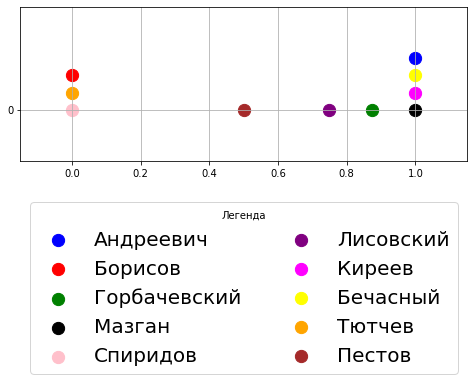

In [356]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

plots = []
colors = ['blue', 'red', 'green', 'black', 'pink', 'purple', 'magenta', 'yellow', 'orange', 'brown']
markers = ['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o']
legend = [
    "Андреевич",
    "Борисов",
    "Горбачевский",
    "Мазган",
    "Спиридов",
    "Лисовский",
    "Киреев",
    "Бечасный",
    "Тютчев",
    "Пестов"
]

point_ids = point_ids_original.copy()
point_ids[:, 1] = np.zeros(10)
# Split coinciding points
resres = get_identical_point_ids(point_ids)
for key in resres.keys():
    ids_coins = resres[key]
    res_spl = split_up_coincident_points(point_ids[ids_coins], 0.05)
    point_ids[ids_coins] = res_spl

#R = create_dist_matrix(point_ids)
R = create_dist_matrix_2(point_ids)
groups = get_alpha_levels(R, point_ids)
#groups.pop(0)
groups.reverse()

# point_ids = point_ids_original.copy()
# # Split coinciding points
# resres = get_identical_point_ids(point_ids)
# for key in resres.keys():
#     ids_coins = resres[key]
#     res_spl = split_coincident_points(point_ids[ids_coins])
#     point_ids[ids_coins] = res_spl[0]

r0 = 0.3

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal')

layers = len(groups)
theta = np.linspace(0, 2*np.pi, 100)
sets_hashes = list()

# Plot the points
ids_to_plot = np.array(list(groups[0][1][0]))
points_to_plot = point_ids[ids_to_plot]
for i in range(len(points_to_plot)):
    p = plt.scatter(points_to_plot[i, 0], points_to_plot[i, 1], s=150, 
                   c=colors[i], marker=markers[i],
                   label=legend[i])
    plots.append(p)

# Create legend with 2 columns
plt.legend(handles=plots, ncol=2, loc='upper center', prop={'size': 20},
          bbox_to_anchor=(0.5, -0.2),
          title='Легенда')

#ax.legend()
#plt.title("Альфа-уровни по двум измерениям с равноценными осями")
ax.set_xlim(-0.15, 1.15)
ax.set_ylim(-0.15, 0.3)
plt.setp(plt.gcf().get_axes(), yticks=[0.0])
plt.grid()
plt.show()

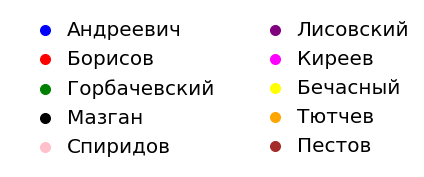

In [357]:
plt.figure(figsize=(7, 3))

colors = ['blue', 'red', 'green', 'black', 'pink', 'purple', 'magenta', 'yellow', 'orange', 'brown']
markers = ['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o']
categories = [
    "Андреевич",
    "Борисов",
    "Горбачевский",
    "Мазган",
    "Спиридов",
    "Лисовский",
    "Киреев",
    "Бечасный",
    "Тютчев",
    "Пестов"
]

# Plot invisible scatter points just for the legend
for lb, color, marker in zip(categories, colors, markers):
    plt.scatter([], [], c=color, marker=marker, label=lb, s=100)

# Customize legend position/style
plt.legend(
    loc="center left",
    frameon=False, ncol=2, prop={'size': 20},
    handletextpad=0.1  # Reduce space between marker and text
)
plt.axis('off')
plt.savefig('legend.jpg')
plt.savefig('legend.pdf')
plt.show()